In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
import functools
import inspect
import emcee
import tqdm
import corner

In [2]:
x_vals = pd.read_csv('../data/testA_rmvdbkg.csv')["bin_centers"]

In [3]:
def gauss_model(x_data, A, mu, sigma, a, b):
    # A, mu, sigma, a, b = params
    bkg = a * x_data + b
    gauss_model = A * np.exp(-0.5 * ((x_data - mu) / sigma) ** 2)
    return bkg + gauss_model

In [4]:
mu_bounds = (1500, 2250)
def log_prior(theta):
    A, mu, sigma, a, b = theta
    if  mu_bounds[0] < mu < mu_bounds[1] and 0 < sigma:
        return 0.0  # log(1) # flat 0 prior inside bounds
    return -np.inf  # log(0)

In [5]:
def gaussian_log_likelihood(x, theta):
    """Calculate the Gaussian log-likelihood for given data."""
    """ P(params|prior) """
    A, mu, sigma, a, b = theta
    # Validate parameters
    if b < 0 or sigma <= 0 or A < 0:
        return -np.inf
    if mu < mu_bounds[0] or mu > mu_bounds[1]:
        return -np.inf
    
    y_model = gauss_model(x, A, mu, sigma, a, b)
    residuals = (y_model - mu)**2
    logL = -1* 0.5 * (1/sigma**2) * np.sum(residuals) #-len(y_model)/2 * np.log(sigma**2) 
    return logL

In [6]:
def log_posterior(theta):
    pri_A, pri_mu, pri_sigma, pri_a, pri_b = theta
    """Calculate the log-posterior for given data and parameters."""
    """log(P(data|params)) + P(params|prior)"""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = gaussian_log_likelihood(x_vals, theta)
    return lp + ll

In [7]:
A, mu, sigma, a, b = 80, 1593, 1, 0, 0 # "true"
ndim = 5

nwalkers = 32
center = np.array([A, mu, sigma, a, b])
p0 = center + 1e-3 * np.random.randn(nwalkers, ndim)

In [9]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
pos, prob, state = sampler.run_mcmc(p0, 3000, progress=True)

100%|██████████| 3000/3000 [00:13<00:00, 216.98it/s]


In [10]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [22.77833307 88.62396089 22.86153818 22.86411944 22.86415431]

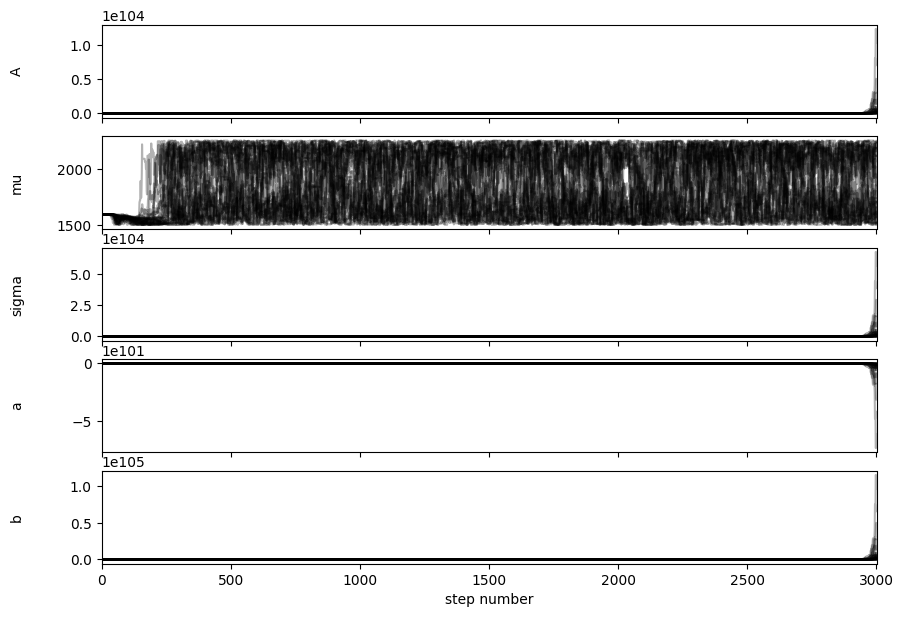

In [11]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['A', 'mu', 'sigma', 'a','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(6176, 5)


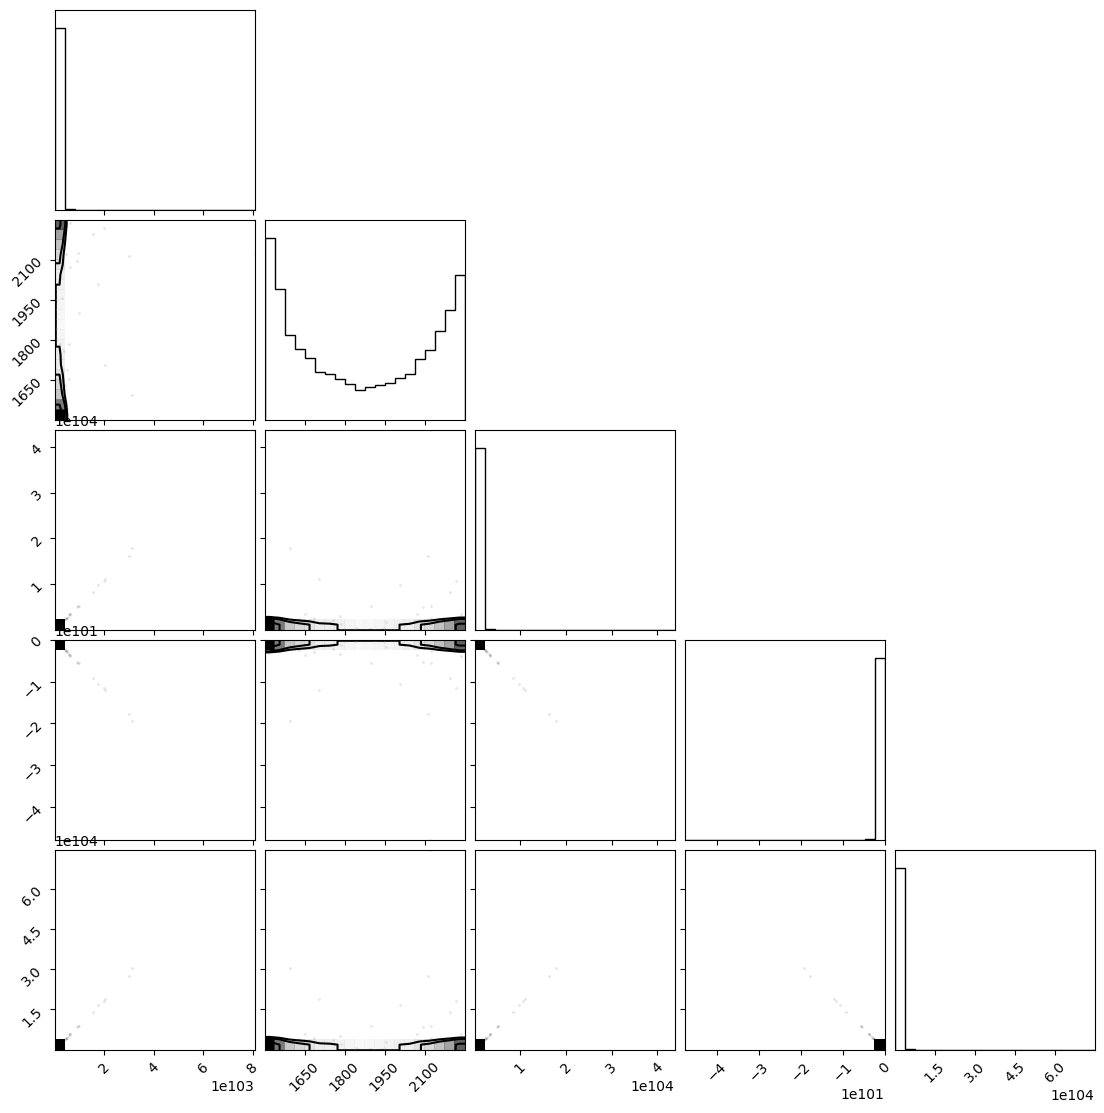

In [12]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples)#, labels=labels, truths=[m_true, b_true, np.log(f_true)]


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
